# Sunspots CHANGE TITLE

In [2]:
# importing the required modules

import numpy as np
from math import degrees
from IPython.display import Image
import sunpy.map
from sunpy.net import Fido, attrs as a
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import astropy.units as u
from astropy.utils.exceptions import AstropyWarning
import warnings
warnings.simplefilter('ignore', category=AstropyWarning)
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib widget
# plt.ioff()

In [3]:
# retrieving images of the Sun
results = Fido.search(a.Time('2015/05/05 12:00', '2015/05/11 12:00'), a.Instrument('HMI'),
                      a.Sample(0.5*u.day), a.Physobs("intensity"))
files = Fido.fetch(results, path="./images/")

# sorting the files alphabetically
files = sorted(files)

#results

Files Downloaded:   0%|          | 0/12 [00:00<?, ?file/s]

The above code retrieved 12 images of the Sun from the HMI instrument on the Solar Dynamics Observatory (SDO) telescope

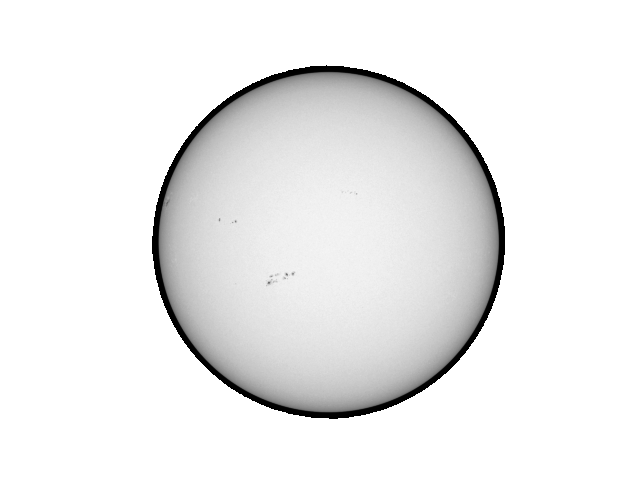

In [4]:
# Creating a SunPy map from the first image
smap = sunpy.map.Map(files[0])

smap = smap.resample((1024, 1024) * u.pix)
smap = smap.rotate(order=3)
fig = plt.imshow(smap.data, cmap='Greys_r', origin='lower')
plt.axis('off')
plt.show()

The code below loads an animation of the Sun from the images that were downloaded.

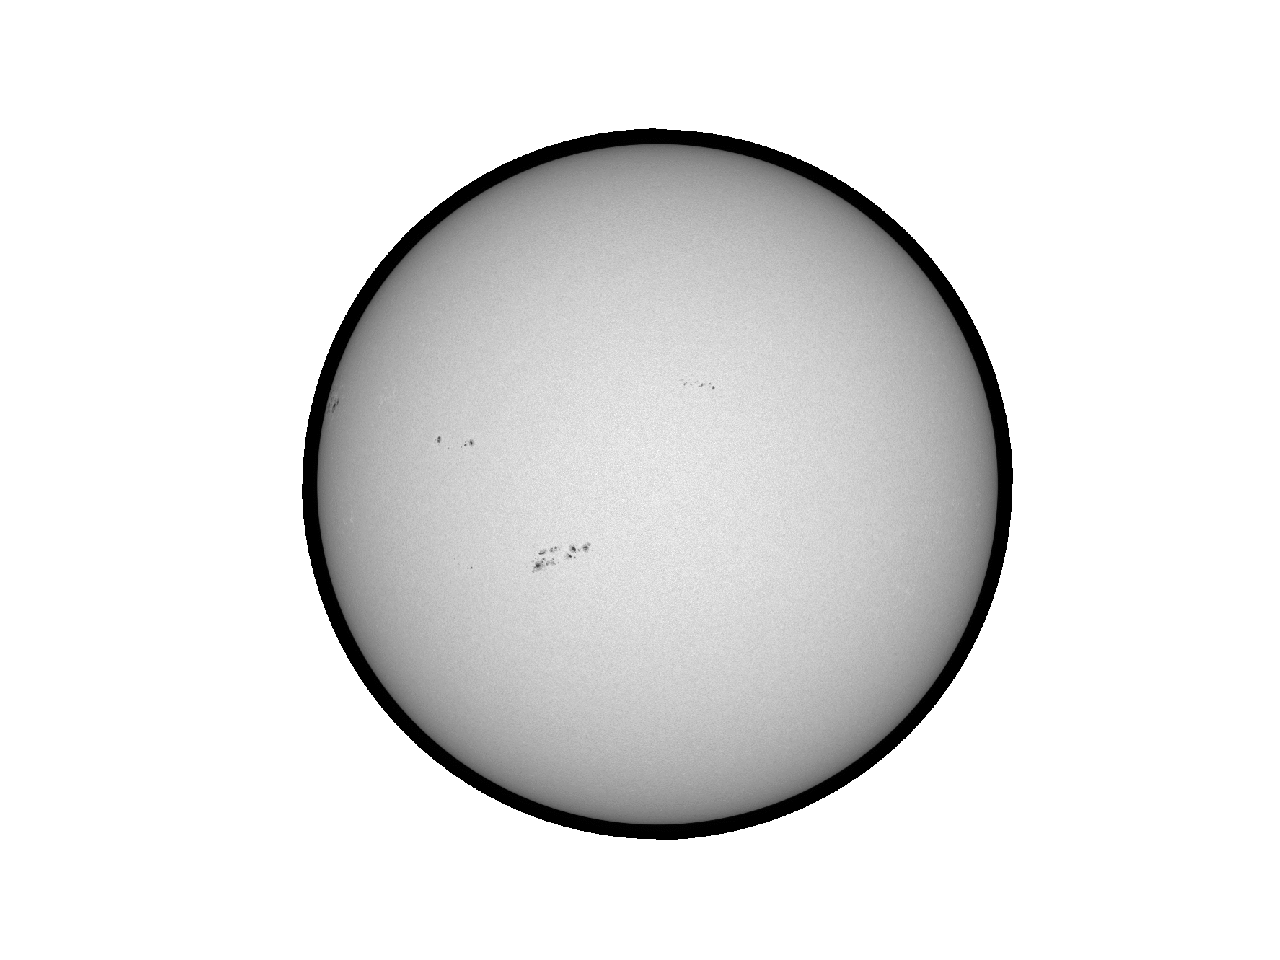

In [5]:
Image('./figures/sunspots.gif')

## Tracking Sunspots <a class="anchor" id="TRACK"></a>

The code below creates a widget that lets us cycle through the set of images we downloaded and make interactive plots of them. Using the widget, we can measure the how the positions of the sunspots change over time in order to determine the Sun's rotation period. 


In [6]:
# will take a minute
smaps = [((sunpy.map.Map(file)).resample((1024, 1024) * u.pix)).rotate(order=3) for file in files]

In [7]:
def map_gen(i):
    plt.figure()
    fig = plt.imshow(smaps[i-1].data, cmap='Greys_r', origin='lower')
    plt.axis('off')
    plt.show();
    
interactive_map = interactive(map_gen, i=widgets.ToggleButtons(
    options=[1,2,3,4,5,6,7,8,9,10,11,12],
    value=1, description='File:', disabled=False)) 
#interactive_map

In [8]:
# x and y coordinates of Sunspot 1 over time, from Image 1 to Image 6 (inclusive)
sunspot1 = np.array([[422,421],[478,424],[530,424],[586,424],[639,424],[689,416]])

# Coordinates of the next two sunspots over time, both from Image 7 to Image 12 (inclusive)

sunspot2 = np.array([[175,621],[214,627],[256,629],[300,632],[347,635],[397,632]])
sunspot3 = np.array([[233,621],[281,627],[331,629],[383,632],[436,632],[492,635]])

sunspots = [sunspot1, sunspot2, sunspot3]

## Calculating the Rotation Period <a class="anchor" id="ROTP"></a>

The motion of a sunspot across the face of the Sun is shown in the image below. Plotting the displacement of the sunspot's x coordinate from the center of the Sun against time yields a sine curve! The relationship between the x displacement and time is:

$$x = A sin\left(\frac{2\pi}{T}t\right)$$

where $A$ is the maximum displacement of a sunspot at a particular latitude from the line of 0 longitude (the y axis), and $T$ is the rotation period. The theory behind this is explored further in the theorySunspots notebook.

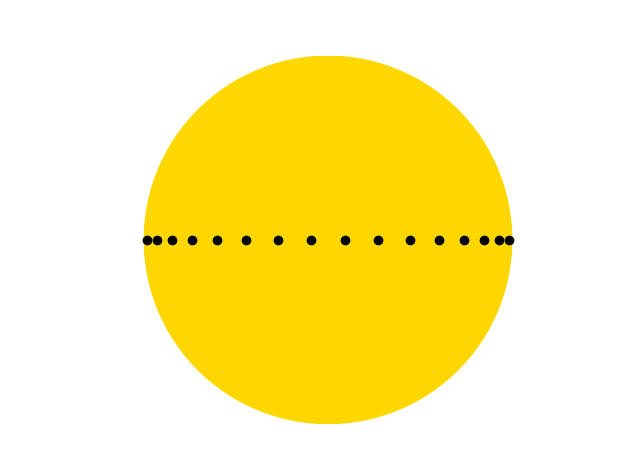

In [9]:
# run me
Image('./figures/theorySunspotsPath.png')

Rearranging the equation above yields:

$$arcsin\left(\frac{x}{A}\right) = \frac{2\pi}{T}t$$

Thus, by plotting $arcsin(x/A)$ against $t$ we can find the slope $m$ which is equal to $\frac{2\pi}{T}$. Rearranging this gives us:

$$T = \frac{2\pi}{m}$$

Before we do this calculation we need $A$ for each sunspot. 

The code below gets the average y value of each sunspot. 

In [11]:
y_avg = [np.mean(sunspot[:,1]) for sunspot in sunspots]

# y_avg returned some decimals but pixel positions are integers, so the y_avg values must be turned into integers

for i in range(len(y_avg)):
    y_avg[i]=int(y_avg[i])

print(y_avg)

[422, 629, 629]


We can find the A value for each sunspot using its y_avg value: Use the cursor to move around in any of the images in the widget until you see y_avg for the y coordinate. Then, move all the way to the edge of the image and note the x position (make sure the y value is still the same). 

In [12]:
# Here, we need to subtract 512 from the x positions to get the max displacement A from the y-axis

A = np.array([984, 974, 974])-512
A

array([472, 462, 462])

Before we do the calculations and make the plot, we need the displacement in x and y from the **center** of the sun. 

In [13]:
# calculating the displacements in x and y by subtracting 512 from each x and y coordinate in each sunspot array
# Your code here:
sunspots_disp = [sunspot-512 for sunspot in sunspots]

sunspots_disp

[array([[-90, -91],
        [-34, -88],
        [ 18, -88],
        [ 74, -88],
        [127, -88],
        [177, -96]]),
 array([[-337,  109],
        [-298,  115],
        [-256,  117],
        [-212,  120],
        [-165,  123],
        [-115,  120]]),
 array([[-279,  109],
        [-231,  115],
        [-181,  117],
        [-129,  120],
        [ -76,  120],
        [ -20,  123]])]

Now we can calculate the $arcsin(x/A)$ and make our first plot of $arcsin(x/A)$ vs $t$.

In [14]:
# calculates arcsin(x/A) for each sunspot and stores the arrays in a list
# [:,0] retrieves the x values of each sunspot

arcsinxA = [np.arcsin(sunspots_disp[i][:,0]/A[i]) for i in range(len(sunspots))]

# creates an array of times from 0 to 60 hours with the same number of points (6) as arcsinxA

t = np.linspace(0,60,6)

arcsinxA

[array([-0.19185274, -0.07209634,  0.03814484,  0.15742914,  0.272425  ,
         0.38439677]),
 array([-0.81749888, -0.70105161, -0.58729651, -0.476728  , -0.36520722,
        -0.25156267]),
 array([-0.64838019, -0.52359878, -0.4025599 , -0.28298252, -0.16525328,
        -0.04330358])]

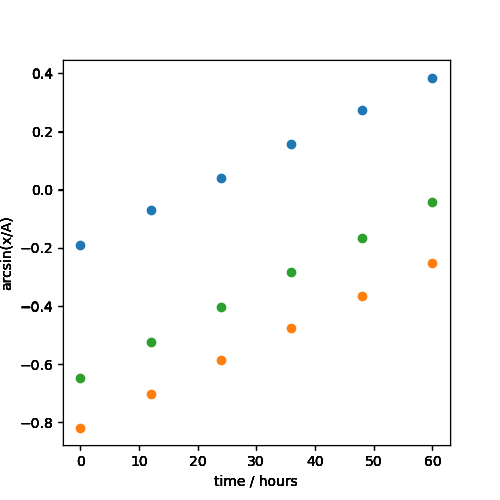

In [26]:
# creates the plot

fig2 = plt.figure(num=2, figsize=(5, 5))
ax2 = fig2.add_subplot(111)
ax2.scatter(t, arcsinxA[0], label='Sunspot 1')
ax2.scatter(t, arcsinxA[1], label='Sunspot 2')
ax2.scatter(t, arcsinxA[2], label='Sunspot 3')
ax2.set_xlabel('time / hours')
ax2.set_ylabel('arcsin(x/A)')
plt.show()

Using the ```np.polyfit()``` function, we can create trendlines for each sunspot and calculate the slope. 

In [27]:
lines = [np.polyfit(t, y, 1) for y in arcsinxA]
lines

[array([ 0.00960499, -0.19007526]),
 array([ 0.00939948, -0.81520863]),
 array([ 0.01004761, -0.64577472])]

Here the first value is the gradient and the second value is the intercept of the straight line fit. We can add them to our plot like this:

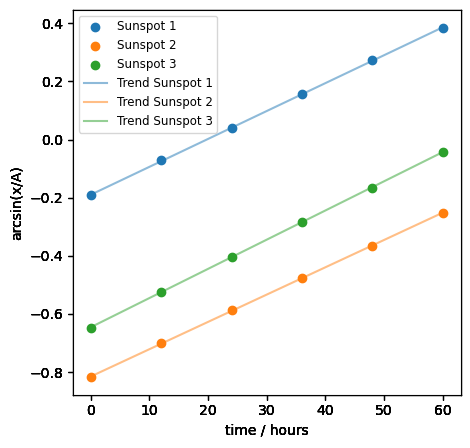

In [28]:
# The first indices are for choosing which line
# The second indices are for choosing the coefficients for each regression

ax2.plot(t, lines[0][0]*t+lines[0][1], label='Trend Sunspot 1', alpha=.5)
ax2.plot(t, lines[1][0]*t+lines[1][1], label='Trend Sunspot 2', alpha=.5)
ax2.plot(t, lines[2][0]*t+lines[2][1], label='Trend Sunspot 3', alpha=.5)
ax2.legend(loc='best',prop={'size': 8.5})
fig2

Now we can calculate the $T$ values using the slopes and then plot them. 

In [30]:
# uses the formula T = 2pi/m to calculate the rotation period for each sunspot
# then turns it into days by dividing by 24 hours

T = [np.round(2*np.pi/line[0]/24,2) for line in lines]

T

[27.26, 27.85, 26.06]

In [31]:
# Calculates the latitude of each sunspot

lats = [np.round(degrees(np.arcsin((y-512)/512)),1) for y in y_avg]
lats

[-10.1, 13.2, 13.2]

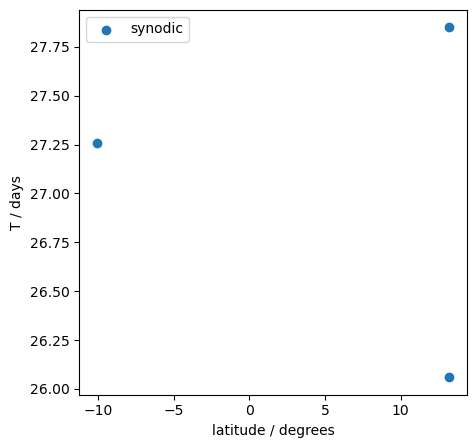

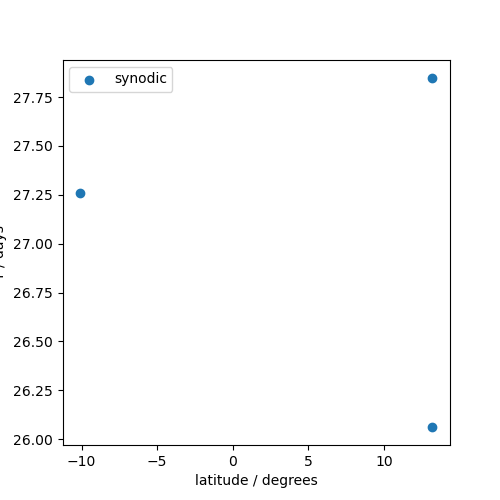

In [33]:
# Creates a plot of rotation period vs latitude

fig3 = plt.figure(figsize=(5, 5))
ax3 = fig3.add_subplot(111)
ax3.set_ylabel('T / days')
ax3.set_xlabel('latitude / degrees')
ax3.scatter(lats, T, label='synodic')
plt.legend()
fig3

## Theoretical Rotation Curve <a class="anchor" id="THEORY"></a>

From the image above, it is evident that the Sun's rotation period changes with latitude. The SunPy module can plot the theoretical rotation curve over our data so we can see how close we got to the correct values.

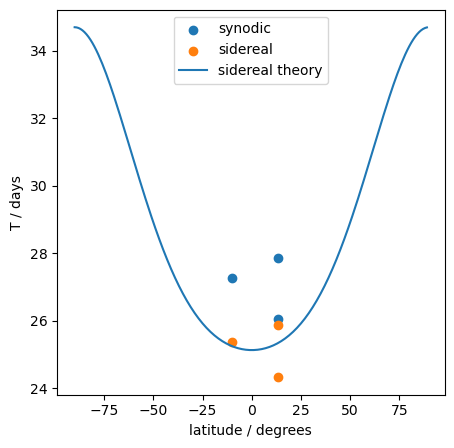

In [34]:
# creates the true rotation curve

from sunpy.physics.differential_rotation import diff_rot

latitudesTheory = np.arange(-90, 90, 1) * u.deg
dt = 1 * u.day
rotation_rate = [diff_rot(dt, this_lat) / dt for this_lat in latitudesTheory]
rotation_period = [360 * u.deg / this_rate for this_rate in rotation_rate]

convert = 360/365.25
deg_per_day = [360/t + convert for t in T]
Tnew = [360/dpd for dpd in deg_per_day]

ax3.scatter(lats,Tnew,label='sidereal')
ax3.plot(latitudesTheory,[this_period.value for this_period in rotation_period],label='sidereal theory')
plt.legend()
fig3

From the theoretical rotation curve, we can see that the Sun rotates fastest at its equator; the rotational period is 25 days at the equator, while at the poles it is 36 days.

The new set of markers in orange are much closer to the theoretical curve. These time periods have been corrected for the movement of the Earth around its orbit to give us the actual or sidereal rotation of the Sun whereas the periods we calculated before were synodic periods. The synodic period is the time taken for the feature (sunspot) to return to the same position as viewed from the Earth, but the Earth itself is rotating around the Sun. The correction factor (how many degrees per day the Earth moves in its orbit, equal to 360/365.25), was added to the degrees per day we observed the sunspots moving.

Our data appears to be offset from the theoretical curve, likely due to errors from our measurements of the pixel coordinates and errors introduced when resampling.

### Sources

1) SunPy - Differential Rotation Code - https://docs.sunpy.org/en/stable/generated/gallery/plotting/simple_differential_rotation.html


2) Roša, D., Brajša, R., Vršnak, B. et al. The relation between the synodic and sidereal rotation period of the Sun. Sol Phys 159, 393–398 (1995). https://doi.org/10.1007/BF00686540

3) scienceinschool - Measuring Solar Rotation - https://www.scienceinschool.org/content/sunspots-rotating-sun